In [1]:
import pandas as pd

In [10]:
df = pd.read_csv("train.csv")
df['Label'] = df['Label'].map({'subjective': 1, 'objective': 0})
df.head()

TextID                                                URL  Label  \
0  Text0080  http://www.dailystar.co.uk/motorsports/view/29...      0   
1  Text0035       http://www.bbc.co.uk/sport/0/tennis/21539758      0   
2  Text0454  http://msn.foxsports.com/foxsoccer/premierleag...      0   
3  Text0211  http://msn.foxsports.com/foxsoccer/seriea/stor...      0   
4  Text0049  http://msn.foxsports.com/boxing/story/Judah-Ga...      0   

   totalWordsCount  semanticobjscore  semanticsubjscore  CC  CD  DT  EX  ...  \
0               47                 2                  0   1   3   0   0  ...   
1               65                 3                  0   3   3   0   4  ...   
2               67                 0                  0   0   7   0   0  ...   
3               69                 4                  1   1   8   0   2  ...   
4               71                 6                  3   2   6   0   2  ...   

   pronouns2nd  pronouns3rd  compsupadjadv  past  imperative  present3rd  \
0            0            0              0     0           0           0   
1            0            2              1     4           0           0   
2            0            0              0     0           0           5   
3            0            1              2     4           0           0   
4            0            0              0     3           0           1   

   present1st2nd  sentence1st  sentencelast  txtcomplexity  
0              3            1             1              9  
1              1            1             1             13  
2              0            1             1             16  
3              1            1             1             17  
4              1            1             1             11  

[5 rows x 62 columns]

In [11]:
## classification problem 2 -> predicting text complexity
df['label_2'] = (df['txtcomplexity'] > df['txtcomplexity'].mean()).astype(int)

In [12]:
df.columns.values

array(['TextID', 'URL', 'Label', 'totalWordsCount', 'semanticobjscore',
       'semanticsubjscore', 'CC', 'CD', 'DT', 'EX', 'FW', 'INs', 'JJ',
       'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS',
       'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TOs', 'UH', 'VB',
       'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB',
       'baseform', 'Quotes', 'questionmarks', 'exclamationmarks',
       'fullstops', 'commas', 'semicolon', 'colon', 'ellipsis',
       'pronouns1st', 'pronouns2nd', 'pronouns3rd', 'compsupadjadv',
       'past', 'imperative', 'present3rd', 'present1st2nd', 'sentence1st',
       'sentencelast', 'txtcomplexity', 'label_2'], dtype=object)

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, QuantileTransformer

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV, validation_curve, learning_curve
from sklearn.metrics import (RocCurveDisplay, precision_recall_curve, roc_curve, det_curve, roc_auc_score, brier_score_loss,
                            confusion_matrix, ConfusionMatrixDisplay, classification_report,
                            make_scorer)

import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

In [14]:
sss = StratifiedShuffleSplit(test_size=0.2, random_state=42, n_splits=2)
for train_idx, test_idx in sss.split(df, df['Label']):
    train_df = df.iloc[train_idx].reset_index(drop=True)
    hold_out_df = df.iloc[test_idx].reset_index(drop=True)
    
sss_2 = StratifiedShuffleSplit(test_size=0.2, random_state=42, n_splits=2)
for train_idx, test_idx in sss_2.split(df, df['label_2']):
    train_df_2 = df.iloc[train_idx].reset_index(drop=True)
    hold_out_df_2 = df.iloc[test_idx].reset_index(drop=True)

In [15]:
px.box(train_df, x='txtcomplexity', color='Label')

In [16]:
px.box(train_df, x='totalWordsCount', color='Label')

In [17]:
frequency_columns = ['CC', 'CD', 'DT', 'EX', 'FW', 'INs', 'JJ',
       'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS',
       'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TOs', 'UH', 'VB',
       'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB',
       'baseform', 'Quotes', 'questionmarks', 'exclamationmarks',
       'fullstops', 'commas', 'semicolon', 'colon', 'ellipsis',
       'pronouns1st', 'pronouns2nd', 'pronouns3rd', 'compsupadjadv',
       'past', 'imperative', 'present3rd', 'present1st2nd','semanticobjscore','semanticsubjscore']

frequency_norm_cols = [col + '_norm' for col in frequency_columns]
train_cols = frequency_norm_cols + ['totalWordsCount_norm','sentence1st','sentencelast']

for col in frequency_columns:
    train_df[col + '_norm'] = train_df[col] / train_df['totalWordsCount']
    hold_out_df[col + '_norm'] = hold_out_df[col] / hold_out_df['totalWordsCount']
    
    train_df_2[col + '_norm'] = train_df_2[col] / train_df_2['totalWordsCount']
    hold_out_df_2[col + '_norm'] = hold_out_df_2[col] / hold_out_df_2['totalWordsCount']

ss_word_count = StandardScaler()

train_df['totalWordsCount_norm'] = ss_word_count.fit_transform(train_df['totalWordsCount'].values.reshape(-1, 1))
hold_out_df['totalWordsCount_norm'] = ss_word_count.transform(hold_out_df['totalWordsCount'].values.reshape(-1, 1))

train_df_2['totalWordsCount_norm'] = ss_word_count.fit_transform(train_df_2['totalWordsCount'].values.reshape(-1, 1))
hold_out_df_2['totalWordsCount_norm'] = ss_word_count.transform(hold_out_df_2['totalWordsCount'].values.reshape(-1, 1))

train_df

TextID                                                URL  Label  \
0    Text0165  http://msn.foxsports.com/horseracing/story/Twi...      0   
1    Text0290  http://www.foxsportsohio.com/01/22/13/Kyrie-dr...      0   
2    Text0554  http://www.nba.com/pistons/features/truebluepi...      0   
3    Text0373  http://msn.foxsports.com/nascar/story/Big-chan...      0   
4    Text0639    http://www.wnba.com/news/cares_week_050812.html      0   
..        ...                                                ...    ...   
795  Text0442  http://www.foxsportssouthwest.com/01/10/13/Num...      1   
796  Text0878  http://www.grantland.com/story/_/id/8683881/ma...      1   
797  Text0508  http://msn.foxsports.com/boxing/story/floyd-ma...      0   
798  Text0697  http://msn.foxsports.com/golf/story/tiger-wood...      1   
799  Text0438  http://msn.foxsports.com/nfl/story/scott-pioli...      0   

     totalWordsCount  semanticobjscore  semanticsubjscore  CC   CD  DT  EX  \
0                692                36                 24   7   49   2  21   
1                651                52                 10  14   58   0   0   
2               1294                87                 11  79  123   1  12   
3                 76                 2                  2   1    7   0   0   
4               1019                38                 22  16   93   0  18   
..               ...               ...                ...  ..  ...  ..  ..   
795             1090                68                 25  14  123   3  10   
796             2442               132                 36  69  244   3  34   
797              981                60                 14  20   67   0   7   
798             1019                49                 26  24   91   4  11   
799              344                17                  5   9   32   1   5   

     ...  pronouns2nd_norm  pronouns3rd_norm  compsupadjadv_norm  past_norm  \
0    ...          0.001445          0.039017            0.011561   0.030347   
1    ...          0.006144          0.021505            0.013825   0.035330   
2    ...          0.000773          0.031685            0.004637   0.056414   
3    ...          0.000000          0.013158            0.000000   0.000000   
4    ...          0.000000          0.004907            0.002944   0.001963   
..   ...               ...               ...                 ...        ...   
795  ...          0.002752          0.035780            0.008257   0.020183   
796  ...          0.003686          0.041769            0.011876   0.039722   
797  ...          0.004077          0.044852            0.013252   0.030581   
798  ...          0.003925          0.037291            0.008832   0.040236   
799  ...          0.000000          0.017442            0.002907   0.040698   

     imperative_norm  present3rd_norm  present1st2nd_norm  \
0           0.005780         0.052023            0.031792   
1           0.006144         0.023041            0.021505   
2           0.003864         0.023184            0.018547   
3           0.013158         0.065789            0.013158   
4           0.009814         0.014720            0.003925   
..               ...              ...                 ...   
795         0.009174         0.023853            0.021101   
796         0.005324         0.033989            0.012285   
797         0.001019         0.036697            0.020387   
798         0.004907         0.040236            0.012758   
799         0.002907         0.017442            0.005814   

     semanticobjscore_norm  semanticsubjscore_norm  totalWordsCount_norm  
0                 0.052023                0.034682              0.018656  
1                 0.079877                0.015361             -0.061847  
2                 0.067233                0.008501              1.200675  
3                 0.026316                0.026316             -1.190852  
4                 0.037291                0.021590              0.660716  
..                     ...           

In [11]:
for col in frequency_norm_cols:
    fig = px.box(train_df, x=col, y='Label')
    fig.show()

In [18]:
exclude = [e + '_norm' for e in ['JJS','NNP','PRP','TOs','VBD','VBG','WP','WRB','exclamationmarks','fullstops','commas','semicolon','colon','ellipsis','EX','FW','INs']]
train_cols = [e for e in train_cols if e not in exclude]

# Decision Tree

Fold 1
Performance before pruning:
Train ROC AUC:  1.0
Test ROC AUC:  0.7283637592968223
Test Confusion Matrix: 


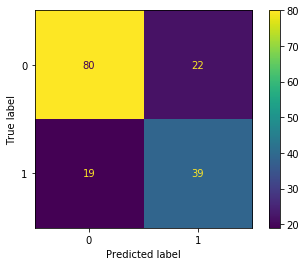

PRUNING


Best Test Performance at: ccp_alpha= 0.005078125
Fold 2
Performance before pruning:
Train ROC AUC:  1.0
Test ROC AUC:  0.7589587559161596
Test Confusion Matrix: 


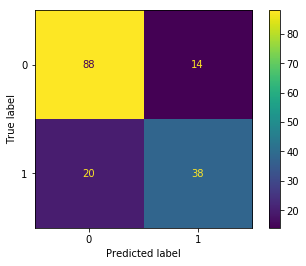

PRUNING


Best Test Performance at: ccp_alpha= 0.005644836848880969
Fold 3
Performance before pruning:
Train ROC AUC:  1.0
Test ROC AUC:  0.7160243407707911
Test Confusion Matrix: 


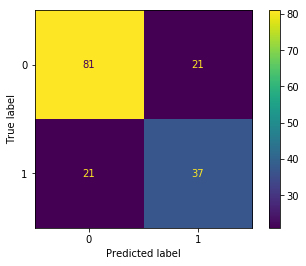

PRUNING


Best Test Performance at: ccp_alpha= 0.011896787423103204
Fold 4
Performance before pruning:
Train ROC AUC:  1.0
Test ROC AUC:  0.7668232924987414
Test Confusion Matrix: 


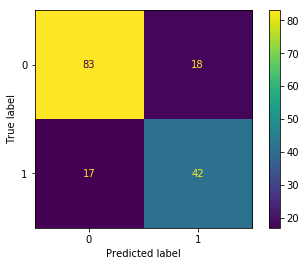

PRUNING


Best Test Performance at: ccp_alpha= 0.005785714285714269
Fold 5
Performance before pruning:
Train ROC AUC:  1.0
Test ROC AUC:  0.6474240644403423
Test Confusion Matrix: 


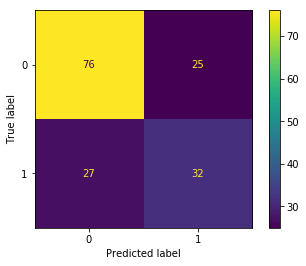

PRUNING


Best Test Performance at: ccp_alpha= 0.007810309229583909


In [19]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=False)
count = 1

for train_idx, test_idx in stratified_cv.split(train_df[train_cols], train_df['Label']):
    print("Fold {}".format(count))
    curr_train_x = train_df[train_cols].iloc[train_idx]
    curr_train_y = train_df['Label'].iloc[train_idx]
    
    curr_test_x = train_df[train_cols].iloc[test_idx]
    curr_test_y = train_df['Label'].iloc[test_idx]
    
    clf = DecisionTreeClassifier(criterion='gini', 
                             splitter='best', 
                             max_depth=None, 
                             min_samples_split=2, 
                             min_samples_leaf=1, 
                             max_features='sqrt', 
                             random_state=42, 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, 
                             ccp_alpha=0.0
                            )
    clf.fit(curr_train_x, curr_train_y)
    curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
    curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
    curr_preds = clf.predict(curr_test_x)
    roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
    roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)
    conf = confusion_matrix(curr_test_y, curr_preds)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=clf.classes_)
    conf_disp.plot()
    print("Performance before pruning:")
    print("Train ROC AUC: ", roc_auc_train)
    print("Test ROC AUC: ", roc_auc_test)
    print("Test Confusion Matrix: ")
    plt.show()
    
    
    print("PRUNING")
    path = clf.cost_complexity_pruning_path(curr_train_x, curr_train_y)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    
    fig = px.scatter(x=ccp_alphas, y=impurities)
    fig.update_layout(xaxis_title='Cost Complexity', yaxis_title='Total Leaf Impurity')
    fig.show()
    pruning_scores = []
    for ccp_alpha in ccp_alphas:
        pruned_dt = DecisionTreeClassifier(criterion='gini', 
                             splitter='best', 
                             max_depth=None, 
                             min_samples_split=2, 
                             min_samples_leaf=1, 
                             max_features='sqrt', 
                             random_state=42, 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, 
                             ccp_alpha=ccp_alpha
                            )
        pruned_dt.fit(curr_train_x, curr_train_y)
        curr_train_probs = pruned_dt.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = pruned_dt.predict_proba(curr_test_x)[:, 1]
        curr_preds = pruned_dt.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)
        pruning_scores.append((ccp_alpha, roc_auc_train, roc_auc_test))
        
    df_pruning = pd.DataFrame(pruning_scores, columns=['Cost Complexity', 'ROC AUC Train', 'ROC AUC Test'])
    fig = px.scatter(df_pruning, x='Cost Complexity', y=['ROC AUC Train', 'ROC AUC Test'])
    fig.show()
    print("Best Test Performance at: ccp_alpha=", df_pruning.sort_values(by='ROC AUC Test', ascending=False)['Cost Complexity'].iloc[0])
    
    count+= 1

Performance:
Train ROC AUC:  0.8325254826879517
Test ROC AUC:  0.8457016503074101
Confusion Matrix: 


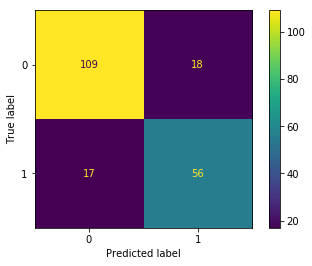

In [20]:
## 0.0078 seems to be decent performance across all folds

clf = DecisionTreeClassifier(criterion='gini', 
                             splitter='best', 
                             max_depth=None, 
                             min_samples_split=2, 
                             min_samples_leaf=1, 
                             max_features='sqrt', 
                             random_state=42, 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, 
                             ccp_alpha=0.0078
                            )
clf.fit(train_df[train_cols], train_df['Label'])
curr_train_probs = clf.predict_proba(train_df[train_cols])[:, 1]
curr_pred_probs = clf.predict_proba(hold_out_df[train_cols])[:, 1]
curr_preds = clf.predict(hold_out_df[train_cols])
roc_auc_train = roc_auc_score(train_df['Label'], curr_train_probs)
roc_auc_test = roc_auc_score(hold_out_df['Label'], curr_pred_probs)
conf = confusion_matrix(hold_out_df['Label'], curr_preds)
conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=clf.classes_)
conf_disp.plot()
print("Performance:")
print("Train ROC AUC: ", roc_auc_train)
print("Test ROC AUC: ", roc_auc_test)
print("Confusion Matrix: ")
plt.show()

In [22]:
## investigating impact of training size on these two models
size_scores = []
for test_size in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
    curr = StratifiedShuffleSplit(n_splits=5, test_size=test_size, random_state=42)
    for train_idx, test_idx in curr.split(train_df[train_cols], train_df['Label']):
        curr_train_x = train_df[train_cols].iloc[train_idx]
        curr_train_y = train_df['Label'].iloc[train_idx]

        curr_test_x = train_df[train_cols].iloc[test_idx]
        curr_test_y = train_df['Label'].iloc[test_idx]
        
        clf = DecisionTreeClassifier(criterion='gini', 
                             splitter='best', 
                             max_depth=None, 
                             min_samples_split=2, 
                             min_samples_leaf=1, 
                             max_features='sqrt', 
                             random_state=42, 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, 
                             ccp_alpha=0.0078
                            )
        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)
        
        size_scores.append((test_size, roc_auc_train, roc_auc_test))
size_scores_df = pd.DataFrame(size_scores, columns=['test_size', 'train_score', 'test_score']) \
.groupby("test_size").agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()

px.line(size_scores_df, x='test_size', y=['train_score', 'test_score'])

Performance:
Train ROC AUC:  0.8867394179894179
Test ROC AUC:  0.8478049832811995
Confusion Matrix: 


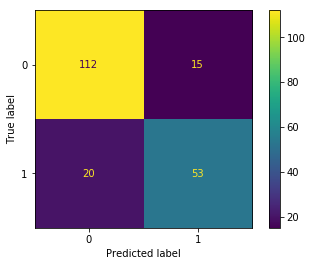

In [23]:
## 0.0078 seems to be decent performance across all folds
curr_train_df = train_df.sample(frac=0.65, random_state=42)

clf = DecisionTreeClassifier(criterion='gini', 
                             splitter='best', 
                             max_depth=None, 
                             min_samples_split=2, 
                             min_samples_leaf=1, 
                             max_features='sqrt', 
                             random_state=42, 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, 
                             ccp_alpha=0.0078
                            )
clf.fit(curr_train_df[train_cols], curr_train_df['Label'])
curr_train_probs = clf.predict_proba(curr_train_df[train_cols])[:, 1]
curr_pred_probs = clf.predict_proba(hold_out_df[train_cols])[:, 1]
curr_preds = clf.predict(hold_out_df[train_cols])
roc_auc_train = roc_auc_score(curr_train_df['Label'], curr_train_probs)
roc_auc_test = roc_auc_score(hold_out_df['Label'], curr_pred_probs)
conf = confusion_matrix(hold_out_df['Label'], curr_preds)
conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=clf.classes_)
conf_disp.plot()
print("Performance:")
print("Train ROC AUC: ", roc_auc_train)
print("Test ROC AUC: ", roc_auc_test)
print("Confusion Matrix: ")
plt.show()

Fold 1
Performance before pruning:
Train ROC AUC:  1.0
Test ROC AUC:  0.5866756167142138
Test Confusion Matrix: 


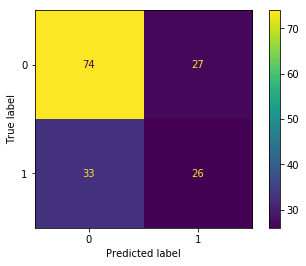

PRUNING


Best Test Performance at: ccp_alpha= 0.004530872584541063
Fold 2
Performance before pruning:
Train ROC AUC:  1.0
Test ROC AUC:  0.7321698271522067
Test Confusion Matrix: 


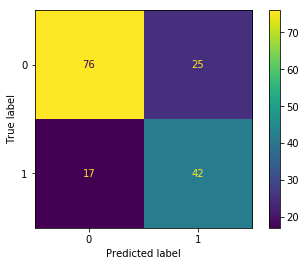

PRUNING


Best Test Performance at: ccp_alpha= 0.002840909090909091
Fold 3
Performance before pruning:
Train ROC AUC:  1.0
Test ROC AUC:  0.6657996308105387
Test Confusion Matrix: 


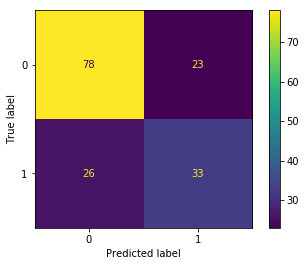

PRUNING


Best Test Performance at: ccp_alpha= 0.003720238095238094
Fold 4
Performance before pruning:
Train ROC AUC:  1.0
Test ROC AUC:  0.6777982883034066
Test Confusion Matrix: 


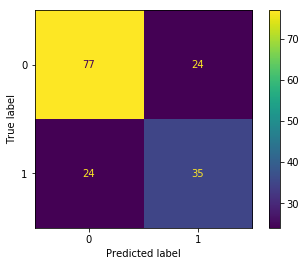

PRUNING


Best Test Performance at: ccp_alpha= 0.0028645833333333336
Fold 5
Performance before pruning:
Train ROC AUC:  1.0
Test ROC AUC:  0.6516666666666666
Test Confusion Matrix: 


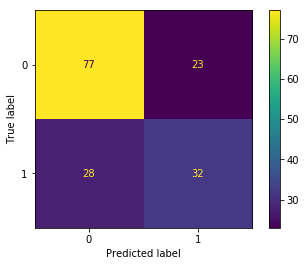

PRUNING


Best Test Performance at: ccp_alpha= 0.003561197916666667


In [26]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=False)
count = 1

for train_idx, test_idx in stratified_cv.split(train_df_2[train_cols], train_df_2['label_2']):
    print("Fold {}".format(count))
    curr_train_x = train_df_2[train_cols].iloc[train_idx]
    curr_train_y = train_df_2['label_2'].iloc[train_idx]
    
    curr_test_x = train_df_2[train_cols].iloc[test_idx]
    curr_test_y = train_df_2['label_2'].iloc[test_idx]
    
    clf = DecisionTreeClassifier(criterion='gini', 
                             splitter='best', 
                             max_depth=None, 
                             min_samples_split=2, 
                             min_samples_leaf=1, 
                             max_features='sqrt', 
                             random_state=42, 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, 
                             ccp_alpha=0.0
                            )
    clf.fit(curr_train_x, curr_train_y)
    curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
    curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
    curr_preds = clf.predict(curr_test_x)
    roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
    roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)
    conf = confusion_matrix(curr_test_y, curr_preds)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=clf.classes_)
    conf_disp.plot()
    print("Performance before pruning:")
    print("Train ROC AUC: ", roc_auc_train)
    print("Test ROC AUC: ", roc_auc_test)
    print("Test Confusion Matrix: ")
    plt.show()
    
    
    print("PRUNING")
    path = clf.cost_complexity_pruning_path(curr_train_x, curr_train_y)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    
    fig = px.scatter(x=ccp_alphas, y=impurities)
    fig.update_layout(xaxis_title='Cost Complexity', yaxis_title='Total Leaf Impurity')
    fig.show()
    pruning_scores = []
    for ccp_alpha in ccp_alphas:
        pruned_dt = DecisionTreeClassifier(criterion='gini', 
                             splitter='best', 
                             max_depth=None, 
                             min_samples_split=2, 
                             min_samples_leaf=1, 
                             max_features='sqrt', 
                             random_state=42, 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, 
                             ccp_alpha=ccp_alpha
                            )
        pruned_dt.fit(curr_train_x, curr_train_y)
        curr_train_probs = pruned_dt.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = pruned_dt.predict_proba(curr_test_x)[:, 1]
        curr_preds = pruned_dt.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)
        pruning_scores.append((ccp_alpha, roc_auc_train, roc_auc_test))
        
    df_pruning = pd.DataFrame(pruning_scores, columns=['Cost Complexity', 'ROC AUC Train', 'ROC AUC Test'])
    fig = px.scatter(df_pruning, x='Cost Complexity', y=['ROC AUC Train', 'ROC AUC Test'])
    fig.show()
    print("Best Test Performance at: ccp_alpha=", df_pruning.sort_values(by='ROC AUC Test', ascending=False)['Cost Complexity'].iloc[0])
    
    count+= 1

Performance:
Train ROC AUC:  0.8300588534963534
Test ROC AUC:  0.7413663663663664
Confusion Matrix: 


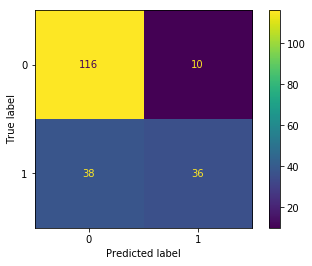

In [27]:
## 0.0078 seems to be decent performance across all folds

clf = DecisionTreeClassifier(criterion='gini', 
                             splitter='best', 
                             max_depth=None, 
                             min_samples_split=2, 
                             min_samples_leaf=1, 
                             max_features='sqrt', 
                             random_state=42, 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, 
                             ccp_alpha=0.0045
                            )
clf.fit(train_df_2[train_cols], train_df_2['label_2'])
curr_train_probs = clf.predict_proba(train_df_2[train_cols])[:, 1]
curr_pred_probs = clf.predict_proba(hold_out_df_2[train_cols])[:, 1]
curr_preds = clf.predict(hold_out_df_2[train_cols])
roc_auc_train = roc_auc_score(train_df_2['label_2'], curr_train_probs)
roc_auc_test = roc_auc_score(hold_out_df_2['label_2'], curr_pred_probs)
conf = confusion_matrix(hold_out_df_2['label_2'], curr_preds)
conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=clf.classes_)
conf_disp.plot()
print("Performance:")
print("Train ROC AUC: ", roc_auc_train)
print("Test ROC AUC: ", roc_auc_test)
print("Confusion Matrix: ")
plt.show()

In [28]:
## investigating impact of training size on these two models
size_scores = []
for test_size in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
    curr = StratifiedShuffleSplit(n_splits=5, test_size=test_size, random_state=42)
    for train_idx, test_idx in curr.split(train_df_2[train_cols], train_df_2['label_2']):
        curr_train_x = train_df_2[train_cols].iloc[train_idx]
        curr_train_y = train_df_2['label_2'].iloc[train_idx]

        curr_test_x = train_df_2[train_cols].iloc[test_idx]
        curr_test_y = train_df_2['label_2'].iloc[test_idx]
        
        clf = DecisionTreeClassifier(criterion='gini', 
                             splitter='best', 
                             max_depth=None, 
                             min_samples_split=2, 
                             min_samples_leaf=1, 
                             max_features='sqrt', 
                             random_state=42, 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, 
                             ccp_alpha=0.0078
                            )
        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)
        
        size_scores.append((test_size, roc_auc_train, roc_auc_test))
size_scores_df = pd.DataFrame(size_scores, columns=['test_size', 'train_score', 'test_score']) \
.groupby("test_size").agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()

px.line(size_scores_df, x='test_size', y=['train_score', 'test_score'])

Performance:
Train ROC AUC:  0.8276945845732745
Test ROC AUC:  0.7368082368082369
Confusion Matrix: 


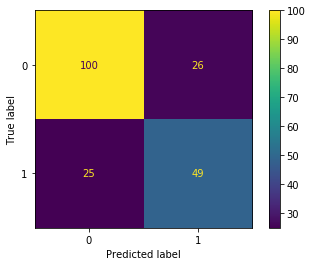

In [29]:
## 0.0078 seems to be decent performance across all folds
curr_train_df = train_df_2.sample(frac=0.65, random_state=42)

clf = DecisionTreeClassifier(criterion='gini', 
                             splitter='best', 
                             max_depth=None, 
                             min_samples_split=2, 
                             min_samples_leaf=1, 
                             max_features='sqrt', 
                             random_state=42, 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, 
                             ccp_alpha=0.0078
                            )
clf.fit(curr_train_df[train_cols], curr_train_df['label_2'])
curr_train_probs = clf.predict_proba(curr_train_df[train_cols])[:, 1]
curr_pred_probs = clf.predict_proba(hold_out_df_2[train_cols])[:, 1]
curr_preds = clf.predict(hold_out_df_2[train_cols])
roc_auc_train = roc_auc_score(curr_train_df['label_2'], curr_train_probs)
roc_auc_test = roc_auc_score(hold_out_df_2['label_2'], curr_pred_probs)
conf = confusion_matrix(hold_out_df_2['label_2'], curr_preds)
conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=clf.classes_)
conf_disp.plot()
print("Performance:")
print("Train ROC AUC: ", roc_auc_train)
print("Test ROC AUC: ", roc_auc_test)
print("Confusion Matrix: ")
plt.show()

# Neural Network

In [68]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=False)
count = 1
scores = []
for train_idx, test_idx in stratified_cv.split(train_df[train_cols], train_df['Label']):
    print("Fold {}".format(count))
    curr_train_x = train_df[train_cols].iloc[train_idx]
    curr_train_y = train_df['Label'].iloc[train_idx]
    
    curr_test_x = train_df[train_cols].iloc[test_idx]
    curr_test_y = train_df['Label'].iloc[test_idx]
    
    for act in ['tanh', 'logistic']:
        clf = MLPClassifier(hidden_layer_sizes=(5,), # 5, 10, 15, 20
                    activation=act, # logistic, tanh
                    solver='adam', # adam, sgd
                    alpha=0.0001, 
                    batch_size='auto', 
                    learning_rate='constant', # constant, adaptive
                    learning_rate_init=0.001, 
                    power_t=0.5, 
                    max_iter=1000,
                    shuffle=True, 
                    random_state=42, 
                    tol=0.0001, 
                    early_stopping=False, # True, False
                    validation_fraction=0.1
                   )

        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)

        scores.append((count, act, roc_auc_train, roc_auc_test))
    count+= 1
val_scores = pd.DataFrame(scores, columns=['fold', 'activation_function', 'train_score', 'test_score']) \
.groupby("activation_function") \
.agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()
px.scatter(val_scores, x='activation_function', y=['train_score', 'test_score'])

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [69]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=False)
count = 1
scores = []
for train_idx, test_idx in stratified_cv.split(train_df[train_cols], train_df['Label']):
    print("Fold {}".format(count))
    curr_train_x = train_df[train_cols].iloc[train_idx]
    curr_train_y = train_df['Label'].iloc[train_idx]
    
    curr_test_x = train_df[train_cols].iloc[test_idx]
    curr_test_y = train_df['Label'].iloc[test_idx]
    
    for hidden_size in [5, 10, 15, 20]:
        clf = MLPClassifier(hidden_layer_sizes=(hidden_size,), # 5, 10, 15, 20
                    activation='tanh', # logistic, tanh
                    solver='adam', # adam, sgd
                    alpha=0.0001, 
                    batch_size='auto', 
                    learning_rate='constant', # constant, adaptive
                    learning_rate_init=0.001, 
                    power_t=0.5, 
                    max_iter=1000,
                    shuffle=True, 
                    random_state=42, 
                    tol=0.0001, 
                    early_stopping=False, # True, False
                    validation_fraction=0.1
                   )

        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)

        scores.append((count, hidden_size, roc_auc_train, roc_auc_test))
    count+= 1
val_scores = pd.DataFrame(scores, columns=['fold', 'size', 'train_score', 'test_score']) \
.groupby("size") \
.agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()
px.scatter(val_scores, x='size', y=['train_score', 'test_score'])

Fold 1
Fold 2
Fold 3
Fold 4


c:\users\dkaraca\appdata\local\programs\python\python36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.



Fold 5


In [75]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=False)
count = 1
scores = []
for train_idx, test_idx in stratified_cv.split(train_df[train_cols], train_df['Label']):
    print("Fold {}".format(count))
    curr_train_x = train_df[train_cols].iloc[train_idx]
    curr_train_y = train_df['Label'].iloc[train_idx]
    
    curr_test_x = train_df[train_cols].iloc[test_idx]
    curr_test_y = train_df['Label'].iloc[test_idx]
    
    for hidden_size in [(10, 10, 5,), (10, 5,), (10,2,), (5,2,), (5,5,2,), (5,5,), (10, 5, 2,)]:
        clf = MLPClassifier(hidden_layer_sizes=hidden_size, # 5, 10, 15, 20
                    activation='tanh', # logistic, tanh
                    solver='adam', # adam, sgd
                    alpha=0.0001, 
                    batch_size='auto', 
                    learning_rate='constant', # constant, adaptive
                    learning_rate_init=0.001, 
                    power_t=0.5, 
                    max_iter=1000,
                    shuffle=True, 
                    random_state=42, 
                    tol=0.0001, 
                    early_stopping=False, # True, False
                    validation_fraction=0.1
                   )

        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)

        scores.append((count, hidden_size, roc_auc_train, roc_auc_test))
    count+= 1
val_scores = pd.DataFrame(scores, columns=['fold', 'size', 'train_score', 'test_score']) \
.groupby("size") \
.agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()
val_scores['size'] = val_scores['size'].apply(lambda x: '|'.join([str(e) for e in list(x)]))
px.scatter(val_scores, x='size', y=['train_score', 'test_score'])

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [76]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=False)
count = 1
scores = []
for train_idx, test_idx in stratified_cv.split(train_df[train_cols], train_df['Label']):
    print("Fold {}".format(count))
    curr_train_x = train_df[train_cols].iloc[train_idx]
    curr_train_y = train_df['Label'].iloc[train_idx]
    
    curr_test_x = train_df[train_cols].iloc[test_idx]
    curr_test_y = train_df['Label'].iloc[test_idx]
    
    for n_iter in [10, 20, 30, 40, 50, 60]:
        clf = MLPClassifier(hidden_layer_sizes=(5,5,), # 5, 10, 15, 20
                    activation='tanh', # logistic, tanh
                    solver='adam', # adam, sgd
                    alpha=0.0001, 
                    batch_size='auto', 
                    learning_rate='constant', # constant, adaptive
                    learning_rate_init=0.001, 
                    power_t=0.5, 
                    max_iter=1000,
                    shuffle=True, 
                    random_state=42, 
                    tol=0.0001, 
                    early_stopping=True, # True, False
                    n_iter_no_change=n_iter,
                    validation_fraction=0.1
                   )

        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)

        scores.append((count, n_iter, roc_auc_train, roc_auc_test))
    count+= 1
val_scores = pd.DataFrame(scores, columns=['fold', 'early_stopping_condition', 'train_score', 'test_score']) \
.groupby("early_stopping_condition") \
.agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()
px.scatter(val_scores, x='early_stopping_condition', y=['train_score', 'test_score'])

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [79]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=False)
count = 1
scores = []
for train_idx, test_idx in stratified_cv.split(train_df[train_cols], train_df['Label']):
    print("Fold {}".format(count))
    curr_train_x = train_df[train_cols].iloc[train_idx]
    curr_train_y = train_df['Label'].iloc[train_idx]
    
    curr_test_x = train_df[train_cols].iloc[test_idx]
    curr_test_y = train_df['Label'].iloc[test_idx]
    
    for learning_rate in ['constant', 'adaptive']:
        clf = MLPClassifier(hidden_layer_sizes=(5,5,), # 5, 10, 15, 20
                    activation='tanh', # logistic, tanh
                    solver='adam', # adam, sgd
                    alpha=0.0001, 
                    batch_size='auto', 
                    learning_rate=learning_rate, # constant, adaptive
                    learning_rate_init=0.001, 
                    power_t=0.5, 
                    max_iter=1000,
                    shuffle=True, 
                    random_state=42, 
                    tol=0.0001, 
                    early_stopping=True, # True, False
                    n_iter_no_change=30,
                    validation_fraction=0.1
                   )

        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)

        scores.append((count, learning_rate, roc_auc_train, roc_auc_test))
    count+= 1
val_scores = pd.DataFrame(scores, columns=['fold', 'learning_rate', 'train_score', 'test_score']) \
.groupby("learning_rate") \
.agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()
px.scatter(val_scores, x='learning_rate', y=['train_score', 'test_score'])

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [80]:
## impact of training size
size_scores = []
for test_size in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
    curr = StratifiedShuffleSplit(n_splits=5, test_size=test_size, random_state=42)
    for train_idx, test_idx in curr.split(train_df[train_cols], train_df['Label']):
        curr_train_x = train_df[train_cols].iloc[train_idx]
        curr_train_y = train_df['Label'].iloc[train_idx]

        curr_test_x = train_df[train_cols].iloc[test_idx]
        curr_test_y = train_df['Label'].iloc[test_idx]
        
        clf = MLPClassifier(hidden_layer_sizes=(5,5,), # 5, 10, 15, 20
                    activation='tanh', # logistic, tanh
                    solver='adam', # adam, sgd
                    alpha=0.0001, 
                    batch_size='auto', 
                    learning_rate=learning_rate, # constant, adaptive
                    learning_rate_init=0.001, 
                    power_t=0.5, 
                    max_iter=1000,
                    shuffle=True, 
                    random_state=42, 
                    tol=0.0001, 
                    early_stopping=True, # True, False
                    n_iter_no_change=30,
                    validation_fraction=0.1
                   )
        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)
        
        size_scores.append((test_size, roc_auc_train, roc_auc_test))
size_scores_df = pd.DataFrame(size_scores, columns=['test_size', 'train_score', 'test_score']) \
.groupby("test_size").agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()

px.line(size_scores_df, x='test_size', y=['train_score', 'test_score'])

Performance:
Train ROC AUC:  0.8309048194570812
Test ROC AUC:  0.8344299428324884
Confusion Matrix: 


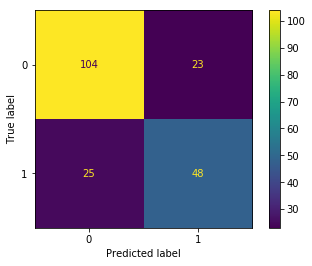

In [81]:
## best performance with ccp_alpha=0.003
curr_train_df = train_df.sample(frac=0.7, random_state=42)
clf = clf = MLPClassifier(hidden_layer_sizes=(5,5,), # 5, 10, 15, 20
                    activation='tanh', # logistic, tanh
                    solver='adam', # adam, sgd
                    alpha=0.0001, 
                    batch_size='auto', 
                    learning_rate=learning_rate, # constant, adaptive
                    learning_rate_init=0.001, 
                    power_t=0.5, 
                    max_iter=1000,
                    shuffle=True, 
                    random_state=42, 
                    tol=0.0001, 
                    early_stopping=True, # True, False
                    n_iter_no_change=30,
                    validation_fraction=0.1
                   )
clf.fit(curr_train_df[train_cols], curr_train_df['Label'])
curr_train_probs = clf.predict_proba(curr_train_df[train_cols])[:, 1]
curr_pred_probs = clf.predict_proba(hold_out_df[train_cols])[:, 1]
curr_preds = clf.predict(hold_out_df[train_cols])
roc_auc_train = roc_auc_score(curr_train_df['Label'], curr_train_probs)
roc_auc_test = roc_auc_score(hold_out_df['Label'], curr_pred_probs)
conf = confusion_matrix(hold_out_df['Label'], curr_preds)
conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=clf.classes_)
conf_disp.plot()
print("Performance:")
print("Train ROC AUC: ", roc_auc_train)
print("Test ROC AUC: ", roc_auc_test)
print("Confusion Matrix: ")
plt.show()

In [85]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=False)
count = 1
scores = []
for train_idx, test_idx in stratified_cv.split(train_df_2[train_cols], train_df_2['label_2']):
    print("Fold {}".format(count))
    curr_train_x = train_df_2[train_cols].iloc[train_idx]
    curr_train_y = train_df_2['label_2'].iloc[train_idx]
    
    curr_test_x = train_df_2[train_cols].iloc[test_idx]
    curr_test_y = train_df_2['label_2'].iloc[test_idx]
    
    for act in ['tanh', 'logistic']:
        clf = MLPClassifier(hidden_layer_sizes=(5,), # 5, 10, 15, 20
                    activation=act, # logistic, tanh
                    solver='adam', # adam, sgd
                    alpha=0.0001, 
                    batch_size='auto', 
                    learning_rate='constant', # constant, adaptive
                    learning_rate_init=0.001, 
                    power_t=0.5, 
                    max_iter=2000,
                    shuffle=True, 
                    random_state=42, 
                    tol=0.0001, 
                    early_stopping=False, # True, False
                    validation_fraction=0.1
                   )

        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)

        scores.append((count, act, roc_auc_train, roc_auc_test))
    count+= 1
val_scores = pd.DataFrame(scores, columns=['fold', 'activation_function', 'train_score', 'test_score']) \
.groupby("activation_function") \
.agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()
px.scatter(val_scores, x='activation_function', y=['train_score', 'test_score'])

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [86]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=False)
count = 1
scores = []
for train_idx, test_idx in stratified_cv.split(train_df_2[train_cols], train_df_2['label_2']):
    print("Fold {}".format(count))
    curr_train_x = train_df_2[train_cols].iloc[train_idx]
    curr_train_y = train_df_2['label_2'].iloc[train_idx]
    
    curr_test_x = train_df_2[train_cols].iloc[test_idx]
    curr_test_y = train_df_2['label_2'].iloc[test_idx]
    
    for hidden_size in [5, 10, 15, 20]:
        clf = MLPClassifier(hidden_layer_sizes=(hidden_size,), # 5, 10, 15, 20
                    activation='tanh', # logistic, tanh
                    solver='adam', # adam, sgd
                    alpha=0.0001, 
                    batch_size='auto', 
                    learning_rate='constant', # constant, adaptive
                    learning_rate_init=0.001, 
                    power_t=0.5, 
                    max_iter=2000,
                    shuffle=True, 
                    random_state=42, 
                    tol=0.0001, 
                    early_stopping=False, # True, False
                    validation_fraction=0.1
                   )

        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)

        scores.append((count, hidden_size, roc_auc_train, roc_auc_test))
    count+= 1
val_scores = pd.DataFrame(scores, columns=['fold', 'size', 'train_score', 'test_score']) \
.groupby("size") \
.agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()
px.scatter(val_scores, x='size', y=['train_score', 'test_score'])

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [93]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=False)
count = 1
scores = []
for train_idx, test_idx in stratified_cv.split(train_df_2[train_cols], train_df_2['label_2']):
    print("Fold {}".format(count))
    curr_train_x = train_df_2[train_cols].iloc[train_idx]
    curr_train_y = train_df_2['label_2'].iloc[train_idx]
    
    curr_test_x = train_df_2[train_cols].iloc[test_idx]
    curr_test_y = train_df_2['label_2'].iloc[test_idx]
    
    for hidden_size in [(10, 10, 5,), (10, 5,), (10,2,), (5,2,), (5,5,2,), (5,5,), (10, 5, 2,)]:
        clf = MLPClassifier(hidden_layer_sizes=hidden_size, # 5, 10, 15, 20
                    activation='tanh', # logistic, tanh
                    solver='adam', # adam, sgd
                    alpha=0.0001, 
                    batch_size='auto', 
                    learning_rate='constant', # constant, adaptive
                    learning_rate_init=0.001, 
                    power_t=0.5, 
                    max_iter=2000,
                    shuffle=True, 
                    random_state=42, 
                    tol=0.0001, 
                    early_stopping=False, # True, False
                    validation_fraction=0.1
                   )

        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)

        scores.append((count, hidden_size, roc_auc_train, roc_auc_test))
    count+= 1
val_scores = pd.DataFrame(scores, columns=['fold', 'size', 'train_score', 'test_score']) \
.groupby("size") \
.agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()
val_scores['size'] = val_scores['size'].apply(lambda x: '|'.join([str(e) for e in list(x)]))
px.scatter(val_scores, x='size', y=['train_score', 'test_score'])

Fold 1


c:\users\dkaraca\appdata\local\programs\python\python36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning:

Training interrupted by user.



Fold 2
Fold 3
Fold 4
Fold 5


In [95]:
## impact of training size
size_scores = []
for test_size in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
    curr = StratifiedShuffleSplit(n_splits=5, test_size=test_size, random_state=42)
    for train_idx, test_idx in curr.split(train_df_2[train_cols], train_df_2['label_2']):
        curr_train_x = train_df_2[train_cols].iloc[train_idx]
        curr_train_y = train_df_2['label_2'].iloc[train_idx]

        curr_test_x = train_df_2[train_cols].iloc[test_idx]
        curr_test_y = train_df_2['label_2'].iloc[test_idx]
        
        clf = MLPClassifier(hidden_layer_sizes=(5,), # 5, 10, 15, 20
                    activation='tanh', # logistic, tanh
                    solver='adam', # adam, sgd
                    alpha=0.0001, 
                    batch_size='auto', 
                    learning_rate=learning_rate, # constant, adaptive
                    learning_rate_init=0.001, 
                    power_t=0.5, 
                    max_iter=2000,
                    shuffle=True, 
                    random_state=42, 
                    tol=0.0001, 
                    early_stopping=False, # True, False
                    n_iter_no_change=30,
                    validation_fraction=0.1
                   )
        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)
        
        size_scores.append((test_size, roc_auc_train, roc_auc_test))
size_scores_df = pd.DataFrame(size_scores, columns=['test_size', 'train_score', 'test_score']) \
.groupby("test_size").agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()

px.line(size_scores_df, x='test_size', y=['train_score', 'test_score'])

c:\users\dkaraca\appdata\local\programs\python\python36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.

c:\users\dkaraca\appdata\local\programs\python\python36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.

c:\users\dkaraca\appdata\local\programs\python\python36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.

c:\users\dkaraca\appdata\local\programs\python\python36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.

c:\u

Performance:
Train ROC AUC:  0.8805152350969084
Test ROC AUC:  0.83000858000858
Confusion Matrix: 


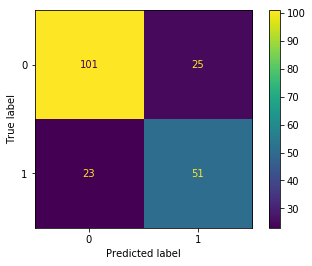

In [98]:
## best performance with ccp_alpha=0.003
curr_train_df = train_df_2.sample(frac=0.85, random_state=42)
clf = clf = MLPClassifier(hidden_layer_sizes=(5,), # 5, 10, 15, 20
                    activation='tanh', # logistic, tanh
                    solver='adam', # adam, sgd
                    alpha=0.0001, 
                    batch_size='auto', 
                    learning_rate=learning_rate, # constant, adaptive
                    learning_rate_init=0.001, 
                    power_t=0.5, 
                    max_iter=5000,
                    shuffle=True, 
                    random_state=42, 
                    tol=0.0001, 
                    early_stopping=False, # True, False
                    n_iter_no_change=30,
                    validation_fraction=0.1
                   )
clf.fit(curr_train_df[train_cols], curr_train_df['label_2'])
curr_train_probs = clf.predict_proba(curr_train_df[train_cols])[:, 1]
curr_pred_probs = clf.predict_proba(hold_out_df_2[train_cols])[:, 1]
curr_preds = clf.predict(hold_out_df_2[train_cols])
roc_auc_train = roc_auc_score(curr_train_df['label_2'], curr_train_probs)
roc_auc_test = roc_auc_score(hold_out_df_2['label_2'], curr_pred_probs)
conf = confusion_matrix(hold_out_df_2['label_2'], curr_preds)
conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=clf.classes_)
conf_disp.plot()
print("Performance:")
print("Train ROC AUC: ", roc_auc_train)
print("Test ROC AUC: ", roc_auc_test)
print("Confusion Matrix: ")
plt.show()

# Boosting

In [30]:
#grid_cv = GridSearchCV(
#    estimator=GradientBoostingClassifier(),
#    param_grid=dict(
#        learning_rate=[0.1, 0.2, 0.05],
#        n_estimators=100, ## 50, 100, 200, 400, 600
#                                 subsample=1.0, ## 0.2 - 0.8,
#         warm_start=False, ## True, False
#            validation_fraction=0.1, ## 0.1 - 0.5
#    ),
#    scoring={
#        'ROC': make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True),
#        'Loss': make_scorer(brier_score_loss, greater_is_better=False, needs_proba=True)
#    },
#    refit=False,
#    cv=StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42),
#    return_train_score=True,
#    error_score=np.nan
#)

#grid_cv.fit(train_df[train_cols], train_df['Label'])

cv_df = pd.read_csv("cv_n_est.csv")
cv_df = cv_df[['param_n_estimators','param_learning_rate','param_subsample','mean_test_ROC', 'mean_train_ROC']].drop_duplicates() \
.rename(columns={
    'param_n_estimators': 'n_est',
    'param_learning_rate': 'l_rate',
    'param_subsample': 'ss'
})
for l_rate, g_df in cv_df.groupby("l_rate"):
    print("Learning Rate: ", l_rate)
    fig = px.line(g_df, x='n_est', y=['mean_train_ROC','mean_test_ROC'], facet_row='ss')
    fig.show()

Learning Rate:  0.05


Learning Rate:  0.1


Learning Rate:  0.2


In [32]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=False)
count = 1
scores = []
for train_idx, test_idx in stratified_cv.split(train_df[train_cols], train_df['Label']):
    print("Fold {}".format(count))
    curr_train_x = train_df[train_cols].iloc[train_idx]
    curr_train_y = train_df['Label'].iloc[train_idx]
    
    curr_test_x = train_df[train_cols].iloc[test_idx]
    curr_test_y = train_df['Label'].iloc[test_idx]
    
    for val_frac in [0.1, 0.2, 0.3, 0.4]:
        clf = GradientBoostingClassifier(loss='deviance', 
                                 learning_rate=0.05, 
                                 n_estimators=200, ## 50, 100, 200, 400, 600
                                 subsample=0.4, ## 0.2 - 0.8
                                 criterion='friedman_mse', 
                                 min_impurity_decrease=0.0, 
                                 init=None, 
                                 random_state=42, 
                                 max_features='sqrt', 
                                 verbose=0, 
                                 warm_start=False, ## True, False
                                 validation_fraction=val_frac, ## 0.1 - 0.5
                                 n_iter_no_change=10, 
                                 tol=0.0001, 
                                 ccp_alpha=0.0
                                )

        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)

        scores.append((count, val_frac, roc_auc_train, roc_auc_test))
    count+= 1
val_scores = pd.DataFrame(scores, columns=['fold', 'val_frac', 'train_score', 'test_score']) \
.groupby("val_frac") \
.agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()
px.scatter(val_scores, x='val_frac', y=['train_score', 'test_score'])

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [33]:
## pruning for models with val_frac=0.2
count = 1
scores = []
for train_idx, test_idx in stratified_cv.split(train_df[train_cols], train_df['Label']):
    print("Fold {}".format(count))
    curr_train_x = train_df[train_cols].iloc[train_idx]
    curr_train_y = train_df['Label'].iloc[train_idx]
    
    curr_test_x = train_df[train_cols].iloc[test_idx]
    curr_test_y = train_df['Label'].iloc[test_idx]
    
    for ccp_alpha in np.linspace(0, 0.05, 100):
        clf = GradientBoostingClassifier(loss='deviance', 
                                 learning_rate=0.05, 
                                 n_estimators=200, ## 50, 100, 200, 400, 600
                                 subsample=0.4, ## 0.2 - 0.8
                                 criterion='friedman_mse', 
                                 min_impurity_decrease=0.0, 
                                 init=None, 
                                 random_state=42, 
                                 max_features='sqrt', 
                                 verbose=0, 
                                 warm_start=False, ## True, False
                                 validation_fraction=0.2, ## 0.1 - 0.5
                                 n_iter_no_change=None, 
                                 tol=0.0001, 
                                 ccp_alpha=ccp_alpha
                                )

        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)

        scores.append((count, ccp_alpha, roc_auc_train, roc_auc_test))
    count+= 1
pruning_scores = pd.DataFrame(scores, columns=['fold', 'ccp_alpha', 'train_score', 'test_score']) \
.groupby("ccp_alpha") \
.agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()
px.scatter(pruning_scores, x='ccp_alpha', y=['train_score', 'test_score'])

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [34]:
## impact of training size
size_scores = []
for test_size in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
    curr = StratifiedShuffleSplit(n_splits=5, test_size=test_size, random_state=42)
    for train_idx, test_idx in curr.split(train_df[train_cols], train_df['Label']):
        curr_train_x = train_df[train_cols].iloc[train_idx]
        curr_train_y = train_df['Label'].iloc[train_idx]

        curr_test_x = train_df[train_cols].iloc[test_idx]
        curr_test_y = train_df['Label'].iloc[test_idx]
        
        clf = GradientBoostingClassifier(loss='deviance', 
                                 learning_rate=0.05, 
                                 n_estimators=200,
                                 subsample=0.4,
                                 criterion='friedman_mse', 
                                 min_impurity_decrease=0.0, 
                                 init=None, 
                                 random_state=42, 
                                 max_features='sqrt', 
                                 verbose=0, 
                                 warm_start=False,
                                 validation_fraction=0.2,
                                 n_iter_no_change=None, 
                                 tol=0.0001, 
                                 ccp_alpha=0.003
                                )
        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)
        
        size_scores.append((test_size, roc_auc_train, roc_auc_test))
size_scores_df = pd.DataFrame(size_scores, columns=['test_size', 'train_score', 'test_score']) \
.groupby("test_size").agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()

px.line(size_scores_df, x='test_size', y=['train_score', 'test_score'])

Performance:
Train ROC AUC:  0.973614524912071
Test ROC AUC:  0.9033545464351203
Confusion Matrix: 


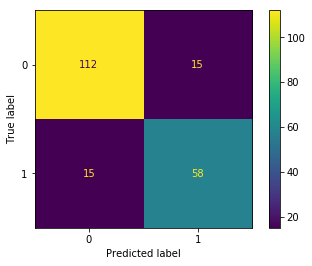

In [35]:
## best performance with ccp_alpha=0.003
curr_train_df = train_df.sample(frac=0.7, random_state=42)
clf = GradientBoostingClassifier(loss='deviance', 
                                 learning_rate=0.05, 
                                 n_estimators=200,
                                 subsample=0.4,
                                 criterion='friedman_mse', 
                                 min_impurity_decrease=0.0, 
                                 init=None, 
                                 random_state=42, 
                                 max_features='sqrt', 
                                 verbose=0, 
                                 warm_start=False,
                                 validation_fraction=0.2,
                                 n_iter_no_change=None, 
                                 tol=0.0001, 
                                 ccp_alpha=0.003
                                )
clf.fit(curr_train_df[train_cols], curr_train_df['Label'])
curr_train_probs = clf.predict_proba(curr_train_df[train_cols])[:, 1]
curr_pred_probs = clf.predict_proba(hold_out_df[train_cols])[:, 1]
curr_preds = clf.predict(hold_out_df[train_cols])
roc_auc_train = roc_auc_score(curr_train_df['Label'], curr_train_probs)
roc_auc_test = roc_auc_score(hold_out_df['Label'], curr_pred_probs)
conf = confusion_matrix(hold_out_df['Label'], curr_preds)
conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=clf.classes_)
conf_disp.plot()
print("Performance:")
print("Train ROC AUC: ", roc_auc_train)
print("Test ROC AUC: ", roc_auc_test)
print("Confusion Matrix: ")
plt.show()

# Boosting - Classification 2

In [63]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=False)
count = 1
scores = []
for train_idx, test_idx in stratified_cv.split(train_df_2[train_cols], train_df_2['label_2']):
    print("Fold {}".format(count))
    curr_train_x = train_df_2[train_cols].iloc[train_idx]
    curr_train_y = train_df_2['label_2'].iloc[train_idx]
    
    curr_test_x = train_df_2[train_cols].iloc[test_idx]
    curr_test_y = train_df_2['label_2'].iloc[test_idx]
    
    for n_est in [50, 100, 150, 200, 250, 300, 350, 400]:
        clf = GradientBoostingClassifier(loss='deviance', 
                                 learning_rate=0.05, 
                                 n_estimators=n_est, ## 50, 100, 200, 400, 600
                                 subsample=0.4, ## 0.2 - 0.8
                                 criterion='friedman_mse', 
                                 min_impurity_decrease=0.0, 
                                 init=None, 
                                 random_state=42, 
                                 max_features='sqrt', 
                                 verbose=0, 
                                 warm_start=False, ## True, False
                                 validation_fraction=0.1, ## 0.1 - 0.5
                                 n_iter_no_change=None, 
                                 tol=0.0001, 
                                 ccp_alpha=0.0
                                )

        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)

        scores.append((count, n_est, roc_auc_train, roc_auc_test))
    count+= 1
val_scores = pd.DataFrame(scores, columns=['fold', 'num_estimators', 'train_score', 'test_score']) \
.groupby("num_estimators") \
.agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()
px.scatter(val_scores, x='num_estimators', y=['train_score', 'test_score'])

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [64]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=False)
count = 1
scores = []
for train_idx, test_idx in stratified_cv.split(train_df_2[train_cols], train_df_2['label_2']):
    print("Fold {}".format(count))
    curr_train_x = train_df_2[train_cols].iloc[train_idx]
    curr_train_y = train_df_2['label_2'].iloc[train_idx]
    
    curr_test_x = train_df_2[train_cols].iloc[test_idx]
    curr_test_y = train_df_2['label_2'].iloc[test_idx]
    
    for l_r in [0.05, 0.1, 0.15, 0.2]:
        clf = GradientBoostingClassifier(loss='deviance', 
                                 learning_rate=l_r, 
                                 n_estimators=100,
                                 subsample=0.4, ## 0.2 - 0.8
                                 criterion='friedman_mse', 
                                 min_impurity_decrease=0.0, 
                                 init=None, 
                                 random_state=42, 
                                 max_features='sqrt', 
                                 verbose=0, 
                                 warm_start=False, ## True, False
                                 validation_fraction=0.1, ## 0.1 - 0.5
                                 n_iter_no_change=None, 
                                 tol=0.0001, 
                                 ccp_alpha=0.0
                                )

        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)

        scores.append((count, l_r, roc_auc_train, roc_auc_test))
    count+= 1
val_scores = pd.DataFrame(scores, columns=['fold', 'learning_rate', 'train_score', 'test_score']) \
.groupby("learning_rate") \
.agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()
px.scatter(val_scores, x='learning_rate', y=['train_score', 'test_score'])

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [65]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=False)
count = 1
scores = []
for train_idx, test_idx in stratified_cv.split(train_df_2[train_cols], train_df_2['label_2']):
    print("Fold {}".format(count))
    curr_train_x = train_df_2[train_cols].iloc[train_idx]
    curr_train_y = train_df_2['label_2'].iloc[train_idx]
    
    curr_test_x = train_df_2[train_cols].iloc[test_idx]
    curr_test_y = train_df_2['label_2'].iloc[test_idx]
    
    for val_frac in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
        clf = GradientBoostingClassifier(loss='deviance', 
                                 learning_rate=0.1, 
                                 n_estimators=100,
                                 subsample=0.4, ## 0.2 - 0.8
                                 criterion='friedman_mse', 
                                 min_impurity_decrease=0.0, 
                                 init=None, 
                                 random_state=42, 
                                 max_features='sqrt', 
                                 verbose=0, 
                                 warm_start=False, ## True, False
                                 validation_fraction=val_frac, ## 0.1 - 0.5
                                 n_iter_no_change=10, 
                                 tol=0.0001, 
                                 ccp_alpha=0.0
                                )

        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)

        scores.append((count, val_frac, roc_auc_train, roc_auc_test))
    count+= 1
val_scores = pd.DataFrame(scores, columns=['fold', 'validation_fraction', 'train_score', 'test_score']) \
.groupby("validation_fraction") \
.agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()
px.scatter(val_scores, x='validation_fraction', y=['train_score', 'test_score'])

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [66]:
## impact of training size
size_scores = []
for test_size in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
    curr = StratifiedShuffleSplit(n_splits=5, test_size=test_size, random_state=42)
    for train_idx, test_idx in curr.split(train_df_2[train_cols], train_df_2['label_2']):
        curr_train_x = train_df_2[train_cols].iloc[train_idx]
        curr_train_y = train_df_2['label_2'].iloc[train_idx]

        curr_test_x = train_df_2[train_cols].iloc[test_idx]
        curr_test_y = train_df_2['label_2'].iloc[test_idx]
        
        clf = GradientBoostingClassifier(loss='deviance', 
                                 learning_rate=0.1, 
                                 n_estimators=100,
                                 subsample=0.4, ## 0.2 - 0.8
                                 criterion='friedman_mse', 
                                 min_impurity_decrease=0.0, 
                                 init=None, 
                                 random_state=42, 
                                 max_features='sqrt', 
                                 verbose=0, 
                                 warm_start=False, ## True, False
                                 validation_fraction=0.1, ## 0.1 - 0.5
                                 n_iter_no_change=10, 
                                 tol=0.0001, 
                                 ccp_alpha=0.0
                                )
        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)
        
        size_scores.append((test_size, roc_auc_train, roc_auc_test))
size_scores_df = pd.DataFrame(size_scores, columns=['test_size', 'train_score', 'test_score']) \
.groupby("test_size").agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()

px.line(size_scores_df, x='test_size', y=['train_score', 'test_score'])

Performance:
Train ROC AUC:  0.9725598086124403
Test ROC AUC:  0.8177820677820677
Confusion Matrix: 


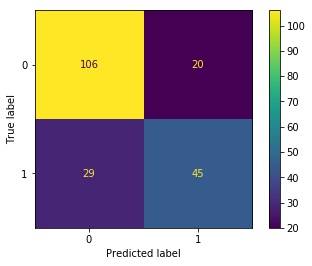

In [67]:
## best performance with ccp_alpha=0.003
curr_train_df = train_df_2.sample(frac=0.75, random_state=42)
clf = GradientBoostingClassifier(loss='deviance', 
                                 learning_rate=0.1, 
                                 n_estimators=100,
                                 subsample=0.4, ## 0.2 - 0.8
                                 criterion='friedman_mse', 
                                 min_impurity_decrease=0.0, 
                                 init=None, 
                                 random_state=42, 
                                 max_features='sqrt', 
                                 verbose=0, 
                                 warm_start=False, ## True, False
                                 validation_fraction=0.1, ## 0.1 - 0.5
                                 n_iter_no_change=10, 
                                 tol=0.0001, 
                                 ccp_alpha=0.0
                                )
clf.fit(curr_train_df[train_cols], curr_train_df['label_2'])
curr_train_probs = clf.predict_proba(curr_train_df[train_cols])[:, 1]
curr_pred_probs = clf.predict_proba(hold_out_df_2[train_cols])[:, 1]
curr_preds = clf.predict(hold_out_df_2[train_cols])
roc_auc_train = roc_auc_score(curr_train_df['label_2'], curr_train_probs)
roc_auc_test = roc_auc_score(hold_out_df_2['label_2'], curr_pred_probs)
conf = confusion_matrix(hold_out_df_2['label_2'], curr_preds)
conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=clf.classes_)
conf_disp.plot()
print("Performance:")
print("Train ROC AUC: ", roc_auc_train)
print("Test ROC AUC: ", roc_auc_test)
print("Confusion Matrix: ")
plt.show()

# Support Vector Machine Classifier

In [36]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=False)
count = 1
scores = []
for train_idx, test_idx in stratified_cv.split(train_df[train_cols], train_df['Label']):
    print("Fold {}".format(count))
    curr_train_x = train_df[train_cols].iloc[train_idx]
    curr_train_y = train_df['Label'].iloc[train_idx]
    
    curr_test_x = train_df[train_cols].iloc[test_idx]
    curr_test_y = train_df['Label'].iloc[test_idx]
    
    for degree in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
        clf = SVC(C=1.0, 
          kernel='poly', 
          degree=degree, 
          gamma='scale', 
          coef0=0.0, 
          shrinking=True, 
          probability=True, 
          tol=0.001, 
          random_state=42
         )

        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)

        scores.append((count, degree, roc_auc_train, roc_auc_test))
    count+= 1
poly_degree_scores = pd.DataFrame(scores, columns=['fold', 'degree', 'train_score', 'test_score']) \
.groupby(['degree']) \
.agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()
#poly_degree_scores['fold'] = 'Fold #' + poly_degree_scores['fold'].astype(str)

px.line(poly_degree_scores, x='degree', y=['train_score', 'test_score'])

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [37]:
## degree above 5 significantly reduces performance, let's investigate the impact of other hyperparameters on model performance
count = 1
scores = []
for train_idx, test_idx in stratified_cv.split(train_df[train_cols], train_df['Label']):
    print("Fold {}".format(count))
    curr_train_x = train_df[train_cols].iloc[train_idx]
    curr_train_y = train_df['Label'].iloc[train_idx]
    
    curr_test_x = train_df[train_cols].iloc[test_idx]
    curr_test_y = train_df['Label'].iloc[test_idx]
    
    for degree in [1, 2, 3, 4, 5, 6, 7, 8]:
        for coef in [0, 0.5, 0.8, 1.0, 1.5, 2.0]:
            clf = SVC(C=1.0, 
              kernel='poly', 
              degree=degree, 
              gamma='scale', 
              coef0=coef, 
              shrinking=True, 
              probability=True, 
              tol=0.001, 
              random_state=42
             )

            clf.fit(curr_train_x, curr_train_y)
            curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
            curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
            curr_preds = clf.predict(curr_test_x)
            roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
            roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)

            scores.append((count, degree, coef, roc_auc_train, roc_auc_test))
    count+= 1
poly_degree_scores = pd.DataFrame(scores, columns=['fold', 'degree', 'coef', 'train_score', 'test_score']) \
.groupby(['degree','coef']) \
.agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()
#poly_degree_scores['fold'] = 'Fold #' + poly_degree_scores['fold'].astype(str)

px.line(poly_degree_scores, x='degree', y=['train_score', 'test_score'], facet_col='coef')

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [38]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=False)
count = 1
scores = []
for train_idx, test_idx in stratified_cv.split(train_df[train_cols], train_df['Label']):
    print("Fold {}".format(count))
    curr_train_x = train_df[train_cols].iloc[train_idx]
    curr_train_y = train_df['Label'].iloc[train_idx]
    
    curr_test_x = train_df[train_cols].iloc[test_idx]
    curr_test_y = train_df['Label'].iloc[test_idx]
    
    for coef in [0, 0.5, 0.8, 1.0, 1.5, 2.0]:
        clf = SVC(C=1.0, 
          kernel='sigmoid', 
          gamma='scale', 
          coef0=0.0, 
          shrinking=True, 
          probability=True, 
          tol=0.001, 
          random_state=42
         )

        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)

        scores.append((count, coef, roc_auc_train, roc_auc_test))
    count+= 1
sig_degree_scores = pd.DataFrame(scores, columns=['fold', 'coef', 'train_score', 'test_score']) \
.groupby(['coef']) \
.agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()
#poly_degree_scores['fold'] = 'Fold #' + poly_degree_scores['fold'].astype(str)

px.line(sig_degree_scores, x='coef', y=['train_score', 'test_score'])

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [39]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=False)
count = 1
scores = []
for train_idx, test_idx in stratified_cv.split(train_df[train_cols], train_df['Label']):
    print("Fold {}".format(count))
    curr_train_x = train_df[train_cols].iloc[train_idx]
    curr_train_y = train_df['Label'].iloc[train_idx]
    
    curr_test_x = train_df[train_cols].iloc[test_idx]
    curr_test_y = train_df['Label'].iloc[test_idx]
    
    clf = SVC(C=1.0, 
      kernel='rbf', 
      gamma='scale', 
      shrinking=True, 
      probability=True, 
      tol=0.001, 
      random_state=42
     )

    clf.fit(curr_train_x, curr_train_y)
    curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
    curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
    curr_preds = clf.predict(curr_test_x)
    roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
    roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)

    scores.append((count, roc_auc_train, roc_auc_test))
    count+= 1
rbf_degree_scores = pd.DataFrame(scores, columns=['fold', 'train_score', 'test_score']) \
.groupby(['fold']) \
.agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()
rbf_degree_scores['fold'] = 'Fold #' + rbf_degree_scores['fold'].astype(str)

px.scatter(rbf_degree_scores, x='fold', y=['train_score', 'test_score'])

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [40]:
## 5th order polynomial kernel with coef0=1.0 vs 6th order polynomial kernel with coef0=2.0
## investigating impact of training size on these two models
size_scores = []
for test_size in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
    curr = StratifiedShuffleSplit(n_splits=5, test_size=test_size, random_state=42)
    for train_idx, test_idx in curr.split(train_df[train_cols], train_df['Label']):
        curr_train_x = train_df[train_cols].iloc[train_idx]
        curr_train_y = train_df['Label'].iloc[train_idx]

        curr_test_x = train_df[train_cols].iloc[test_idx]
        curr_test_y = train_df['Label'].iloc[test_idx]
        
        clf = SVC(C=1.0, 
              kernel='poly', 
              degree=5, 
              gamma='scale', 
              coef0=1.0, 
              shrinking=True, 
              probability=True, 
              tol=0.001, 
              random_state=42
             )
        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)
        
        size_scores.append((test_size, roc_auc_train, roc_auc_test))
size_scores_df = pd.DataFrame(size_scores, columns=['test_size', 'train_score', 'test_score']) \
.groupby("test_size").agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()

px.line(size_scores_df, x='test_size', y=['train_score', 'test_score'])

In [41]:
size_scores = []
for test_size in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
    curr = StratifiedShuffleSplit(n_splits=5, test_size=test_size, random_state=42)
    for train_idx, test_idx in curr.split(train_df[train_cols], train_df['Label']):
        curr_train_x = train_df[train_cols].iloc[train_idx]
        curr_train_y = train_df['Label'].iloc[train_idx]

        curr_test_x = train_df[train_cols].iloc[test_idx]
        curr_test_y = train_df['Label'].iloc[test_idx]
        
        clf = SVC(C=1.0, 
              kernel='poly', 
              degree=6, 
              gamma='scale', 
              coef0=2.0, 
              shrinking=True, 
              probability=True, 
              tol=0.001, 
              random_state=42
             )
        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)
        
        size_scores.append((test_size, roc_auc_train, roc_auc_test))
size_scores_df = pd.DataFrame(size_scores, columns=['test_size', 'train_score', 'test_score']) \
.groupby("test_size").agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()

px.line(size_scores_df, x='test_size', y=['train_score', 'test_score'])

Performance:
Train ROC AUC:  0.8918236260677087
Test ROC AUC:  0.9088555711357997
Confusion Matrix: 


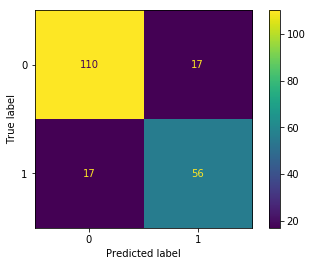

In [42]:
## test_size=0.3 gives best test set performance
curr_train_df = train_df.sample(frac=0.7, random_state=42)

clf = SVC(C=1.0, 
              kernel='poly', 
              degree=5, 
              gamma='scale', 
              coef0=1.0, 
              shrinking=True, 
              probability=True, 
              tol=0.001, 
              random_state=42
             )
clf.fit(curr_train_df[train_cols], curr_train_df['Label'])
curr_train_probs = clf.predict_proba(curr_train_df[train_cols])[:, 1]
curr_pred_probs = clf.predict_proba(hold_out_df[train_cols])[:, 1]
curr_preds = clf.predict(hold_out_df[train_cols])
roc_auc_train = roc_auc_score(curr_train_df['Label'], curr_train_probs)
roc_auc_test = roc_auc_score(hold_out_df['Label'], curr_pred_probs)
conf = confusion_matrix(hold_out_df['Label'], curr_preds)
conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=clf.classes_)
conf_disp.plot()
print("Performance:")
print("Train ROC AUC: ", roc_auc_train)
print("Test ROC AUC: ", roc_auc_test)
print("Confusion Matrix: ")
plt.show()

# Support Vector Machine - Classification 2

In [55]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=False)
count = 1
scores = []
for train_idx, test_idx in stratified_cv.split(train_df_2[train_cols], train_df_2['label_2']):
    print("Fold {}".format(count))
    curr_train_x = train_df_2[train_cols].iloc[train_idx]
    curr_train_y = train_df_2['label_2'].iloc[train_idx]
    
    curr_test_x = train_df_2[train_cols].iloc[test_idx]
    curr_test_y = train_df_2['label_2'].iloc[test_idx]
    
    for degree in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
        clf = SVC(C=1.0, 
          kernel='poly', 
          degree=degree, 
          gamma='scale', 
          coef0=0.0, 
          shrinking=True, 
          probability=True, 
          tol=0.001, 
          random_state=42
         )

        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)

        scores.append((count, degree, roc_auc_train, roc_auc_test))
    count+= 1
poly_degree_scores = pd.DataFrame(scores, columns=['fold', 'degree', 'train_score', 'test_score']) \
.groupby(['degree']) \
.agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()
#poly_degree_scores['fold'] = 'Fold #' + poly_degree_scores['fold'].astype(str)

px.line(poly_degree_scores, x='degree', y=['train_score', 'test_score'])

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [56]:
## degree above 5 significantly reduces performance, let's investigate the impact of other hyperparameters on model performance
count = 1
scores = []
for train_idx, test_idx in stratified_cv.split(train_df_2[train_cols], train_df_2['label_2']):
    print("Fold {}".format(count))
    curr_train_x = train_df_2[train_cols].iloc[train_idx]
    curr_train_y = train_df_2['label_2'].iloc[train_idx]
    
    curr_test_x = train_df_2[train_cols].iloc[test_idx]
    curr_test_y = train_df_2['label_2'].iloc[test_idx]
    
    for degree in [1, 2, 3, 4, 5, 6, 7, 8]:
        for coef in [0, 0.5, 0.8, 1.0, 1.5, 2.0]:
            clf = SVC(C=1.0, 
              kernel='poly', 
              degree=degree, 
              gamma='scale', 
              coef0=coef, 
              shrinking=True, 
              probability=True, 
              tol=0.001, 
              random_state=42
             )

            clf.fit(curr_train_x, curr_train_y)
            curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
            curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
            curr_preds = clf.predict(curr_test_x)
            roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
            roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)

            scores.append((count, degree, coef, roc_auc_train, roc_auc_test))
    count+= 1
poly_degree_scores = pd.DataFrame(scores, columns=['fold', 'degree', 'coef', 'train_score', 'test_score']) \
.groupby(['degree','coef']) \
.agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()
#poly_degree_scores['fold'] = 'Fold #' + poly_degree_scores['fold'].astype(str)

px.line(poly_degree_scores, x='degree', y=['train_score', 'test_score'], facet_col='coef')

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [57]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=False)
count = 1
scores = []
for train_idx, test_idx in stratified_cv.split(train_df_2[train_cols], train_df_2['label_2']):
    print("Fold {}".format(count))
    curr_train_x = train_df_2[train_cols].iloc[train_idx]
    curr_train_y = train_df_2['label_2'].iloc[train_idx]
    
    curr_test_x = train_df_2[train_cols].iloc[test_idx]
    curr_test_y = train_df_2['label_2'].iloc[test_idx]
    
    for coef in [0, 0.5, 0.8, 1.0, 1.5, 2.0]:
        clf = SVC(C=1.0, 
          kernel='sigmoid', 
          gamma='scale', 
          coef0=0.0, 
          shrinking=True, 
          probability=True, 
          tol=0.001, 
          random_state=42
         )

        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)

        scores.append((count, coef, roc_auc_train, roc_auc_test))
    count+= 1
sig_degree_scores = pd.DataFrame(scores, columns=['fold', 'coef', 'train_score', 'test_score']) \
.groupby(['coef']) \
.agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()
#poly_degree_scores['fold'] = 'Fold #' + poly_degree_scores['fold'].astype(str)

px.line(sig_degree_scores, x='coef', y=['train_score', 'test_score'])

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [58]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=False)
count = 1
scores = []
for train_idx, test_idx in stratified_cv.split(train_df_2[train_cols], train_df_2['label_2']):
    print("Fold {}".format(count))
    curr_train_x = train_df_2[train_cols].iloc[train_idx]
    curr_train_y = train_df_2['label_2'].iloc[train_idx]
    
    curr_test_x = train_df_2[train_cols].iloc[test_idx]
    curr_test_y = train_df_2['label_2'].iloc[test_idx]
    
    clf = SVC(C=1.0, 
      kernel='rbf', 
      gamma='scale', 
      shrinking=True, 
      probability=True, 
      tol=0.001, 
      random_state=42
     )

    clf.fit(curr_train_x, curr_train_y)
    curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
    curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
    curr_preds = clf.predict(curr_test_x)
    roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
    roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)

    scores.append((count, roc_auc_train, roc_auc_test))
    count+= 1
rbf_degree_scores = pd.DataFrame(scores, columns=['fold', 'train_score', 'test_score']) \
.groupby(['fold']) \
.agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()
rbf_degree_scores['fold'] = 'Fold #' + rbf_degree_scores['fold'].astype(str)

px.scatter(rbf_degree_scores, x='fold', y=['train_score', 'test_score'])

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [59]:
## 5th order polynomial kernel with coef0=1.0 vs 6th order polynomial kernel with coef0=2.0
## investigating impact of training size on these two models
size_scores = []
for test_size in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
    curr = StratifiedShuffleSplit(n_splits=5, test_size=test_size, random_state=42)
    for train_idx, test_idx in curr.split(train_df_2[train_cols], train_df_2['label_2']):
        curr_train_x = train_df_2[train_cols].iloc[train_idx]
        curr_train_y = train_df_2['label_2'].iloc[train_idx]

        curr_test_x = train_df_2[train_cols].iloc[test_idx]
        curr_test_y = train_df_2['label_2'].iloc[test_idx]
        
        clf = SVC(C=1.0, 
              kernel='poly', 
              degree=5, 
              gamma='scale', 
              coef0=2.0, 
              shrinking=True, 
              probability=True, 
              tol=0.001, 
              random_state=42
             )
        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)
        
        size_scores.append((test_size, roc_auc_train, roc_auc_test))
size_scores_df = pd.DataFrame(size_scores, columns=['test_size', 'train_score', 'test_score']) \
.groupby("test_size").agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()

px.line(size_scores_df, x='test_size', y=['train_score', 'test_score'])

Performance:
Train ROC AUC:  0.8749709785566359
Test ROC AUC:  0.8050729300729301
Confusion Matrix: 


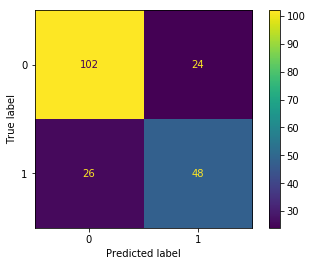

In [60]:
## test_size=0.3 gives best test set performance
curr_train_df = train_df_2.sample(frac=0.85, random_state=42)

clf = SVC(C=1.0, 
              kernel='poly', 
              degree=5, 
              gamma='scale', 
              coef0=2.0, 
              shrinking=True, 
              probability=True, 
              tol=0.001, 
              random_state=42
             )
clf.fit(curr_train_df[train_cols], curr_train_df['label_2'])
curr_train_probs = clf.predict_proba(curr_train_df[train_cols])[:, 1]
curr_pred_probs = clf.predict_proba(hold_out_df_2[train_cols])[:, 1]
curr_preds = clf.predict(hold_out_df_2[train_cols])
roc_auc_train = roc_auc_score(curr_train_df['label_2'], curr_train_probs)
roc_auc_test = roc_auc_score(hold_out_df_2['label_2'], curr_pred_probs)
conf = confusion_matrix(hold_out_df_2['label_2'], curr_preds)
conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=clf.classes_)
conf_disp.plot()
print("Performance:")
print("Train ROC AUC: ", roc_auc_train)
print("Test ROC AUC: ", roc_auc_test)
print("Confusion Matrix: ")
plt.show()

# KNN-Classifier

In [43]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=False)
count = 1
scores = []
for train_idx, test_idx in stratified_cv.split(train_df[train_cols], train_df['Label']):
    print("Fold {}".format(count))
    curr_train_x = train_df[train_cols].iloc[train_idx]
    curr_train_y = train_df['Label'].iloc[train_idx]
    
    curr_test_x = train_df[train_cols].iloc[test_idx]
    curr_test_y = train_df['Label'].iloc[test_idx]
    
    for k in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]:
    
        clf = KNeighborsClassifier(n_neighbors=k, ## search
                               weights='uniform', ## uniform, distance
                               algorithm='brute', 
                               metric='cosine', ## euclidean 
                               n_jobs=None
                              )

        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)
        
        scores.append((count, k, 'uniform', 'cosine', roc_auc_train, roc_auc_test))

    for k in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]:
    
        clf = KNeighborsClassifier(n_neighbors=k, ## search
                               weights='uniform', ## uniform, distance
                               algorithm='brute', 
                               metric='euclidean', ## euclidean 
                               n_jobs=None
                              )

        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)
        
        scores.append((count, k, 'uniform', 'euclidean', roc_auc_train, roc_auc_test))
        
    for k in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]:
    
        clf = KNeighborsClassifier(n_neighbors=k, ## search
                               weights='distance', ## uniform, distance
                               algorithm='brute', 
                               metric='cosine', ## euclidean 
                               n_jobs=None
                              )

        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)
        
        scores.append((count, k, 'distance', 'cosine', roc_auc_train, roc_auc_test))
        
    for k in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]:
    
        clf = KNeighborsClassifier(n_neighbors=k, ## search
                               weights='distance', ## uniform, distance
                               algorithm='brute', 
                               metric='euclidean', ## euclidean 
                               n_jobs=None
                              )

        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)
        
        scores.append((count, k, 'distance', 'euclidean', roc_auc_train, roc_auc_test))
    
    count+= 1
knn_performance = pd.DataFrame(scores, columns=['fold', 'k', 'weights', 'distance', 'train_score', 'test_score']) \
.groupby(['k','weights','distance']) \
.agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()
px.line(knn_performance, x='k', y=['train_score','test_score'], facet_col='weights', facet_row='distance')

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [44]:
## distance weighting + k=20 + cosine distance combination gives the best test performance across 5-fold cross validation 
## let's investigate the impact of training size on test performance

size_scores = []
for test_size in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
    curr = StratifiedShuffleSplit(n_splits=5, test_size=test_size, random_state=42)
    for train_idx, test_idx in curr.split(train_df[train_cols], train_df['Label']):
        curr_train_x = train_df[train_cols].iloc[train_idx]
        curr_train_y = train_df['Label'].iloc[train_idx]

        curr_test_x = train_df[train_cols].iloc[test_idx]
        curr_test_y = train_df['Label'].iloc[test_idx]
        
        clf = KNeighborsClassifier(n_neighbors=20, ## search
                               weights='distance', ## uniform, distance
                               algorithm='brute', 
                               metric='cosine', ## euclidean 
                               n_jobs=None
                              )
        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)
        
        size_scores.append((test_size, roc_auc_train, roc_auc_test))
size_scores_df = pd.DataFrame(size_scores, columns=['test_size', 'train_score', 'test_score']) \
.groupby("test_size").agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()

px.line(size_scores_df, x='test_size', y=['train_score', 'test_score'])

Performance:
Train ROC AUC:  1.0
Test ROC AUC:  0.860640707582785
Confusion Matrix: 


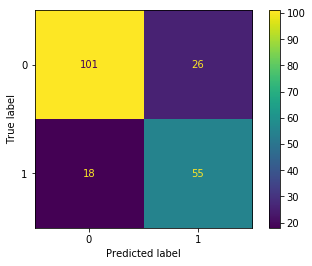

In [45]:
## test_size=0.3 gives best test set performance
curr_train_df = train_df.sample(frac=0.7, random_state=42)

clf = KNeighborsClassifier(n_neighbors=20, ## search
                               weights='distance', ## uniform, distance
                               algorithm='brute', 
                               metric='cosine', ## euclidean 
                               n_jobs=None
                              )
clf.fit(curr_train_df[train_cols], curr_train_df['Label'])
curr_train_probs = clf.predict_proba(curr_train_df[train_cols])[:, 1]
curr_pred_probs = clf.predict_proba(hold_out_df[train_cols])[:, 1]
curr_preds = clf.predict(hold_out_df[train_cols])
roc_auc_train = roc_auc_score(curr_train_df['Label'], curr_train_probs)
roc_auc_test = roc_auc_score(hold_out_df['Label'], curr_pred_probs)
conf = confusion_matrix(hold_out_df['Label'], curr_preds)
conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=clf.classes_)
conf_disp.plot()
print("Performance:")
print("Train ROC AUC: ", roc_auc_train)
print("Test ROC AUC: ", roc_auc_test)
print("Confusion Matrix: ")
plt.show()

# K-NN - Classification Problem 2

In [46]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=False)
count = 1
scores = []
for train_idx, test_idx in stratified_cv.split(train_df_2[train_cols], train_df_2['label_2']):
    print("Fold {}".format(count))
    curr_train_x = train_df_2[train_cols].iloc[train_idx]
    curr_train_y = train_df_2['label_2'].iloc[train_idx]
    
    curr_test_x = train_df_2[train_cols].iloc[test_idx]
    curr_test_y = train_df_2['label_2'].iloc[test_idx]
    
    for k in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]:
    
        clf = KNeighborsClassifier(n_neighbors=k, ## search
                               weights='uniform', ## uniform, distance
                               algorithm='brute', 
                               metric='cosine', ## euclidean 
                               n_jobs=None
                              )

        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)
        
        scores.append((count, k, 'uniform', 'cosine', roc_auc_train, roc_auc_test))

    for k in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]:
    
        clf = KNeighborsClassifier(n_neighbors=k, ## search
                               weights='uniform', ## uniform, distance
                               algorithm='brute', 
                               metric='euclidean', ## euclidean 
                               n_jobs=None
                              )

        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)
        
        scores.append((count, k, 'uniform', 'euclidean', roc_auc_train, roc_auc_test))
        
    for k in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]:
    
        clf = KNeighborsClassifier(n_neighbors=k, ## search
                               weights='distance', ## uniform, distance
                               algorithm='brute', 
                               metric='cosine', ## euclidean 
                               n_jobs=None
                              )

        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)
        
        scores.append((count, k, 'distance', 'cosine', roc_auc_train, roc_auc_test))
        
    for k in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]:
    
        clf = KNeighborsClassifier(n_neighbors=k, ## search
                               weights='distance', ## uniform, distance
                               algorithm='brute', 
                               metric='euclidean', ## euclidean 
                               n_jobs=None
                              )

        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)
        
        scores.append((count, k, 'distance', 'euclidean', roc_auc_train, roc_auc_test))
    
    count+= 1
knn_performance = pd.DataFrame(scores, columns=['fold', 'k', 'weights', 'distance', 'train_score', 'test_score']) \
.groupby(['k','weights','distance']) \
.agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()
px.line(knn_performance, x='k', y=['train_score','test_score'], facet_col='weights', facet_row='distance')

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [52]:
## distance weighting + k=25 + cosine distance combination gives the best test performance across 5-fold cross validation 
## let's investigate the impact of training size on test performance

size_scores = []
for test_size in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
    curr = StratifiedShuffleSplit(n_splits=5, test_size=test_size, random_state=42)
    for train_idx, test_idx in curr.split(train_df_2[train_cols], train_df_2['label_2']):
        curr_train_x = train_df_2[train_cols].iloc[train_idx]
        curr_train_y = train_df_2['label_2'].iloc[train_idx]

        curr_test_x = train_df_2[train_cols].iloc[test_idx]
        curr_test_y = train_df_2['label_2'].iloc[test_idx]
        
        clf = KNeighborsClassifier(n_neighbors=25, ## search
                               weights='distance', ## uniform, distance
                               algorithm='brute', 
                               metric='cosine', ## euclidean 
                               n_jobs=None
                              )
        clf.fit(curr_train_x, curr_train_y)
        curr_train_probs = clf.predict_proba(curr_train_x)[:, 1]
        curr_pred_probs = clf.predict_proba(curr_test_x)[:, 1]
        curr_preds = clf.predict(curr_test_x)
        roc_auc_train = roc_auc_score(curr_train_y, curr_train_probs)
        roc_auc_test = roc_auc_score(curr_test_y, curr_pred_probs)
        
        size_scores.append((test_size, roc_auc_train, roc_auc_test))
size_scores_df = pd.DataFrame(size_scores, columns=['test_size', 'train_score', 'test_score']) \
.groupby("test_size").agg({'train_score': 'mean', 'test_score': 'mean'}).reset_index()

px.line(size_scores_df, x='test_size', y=['train_score', 'test_score'])

Performance:
Train ROC AUC:  1.0
Test ROC AUC:  0.6768554268554269
Confusion Matrix: 


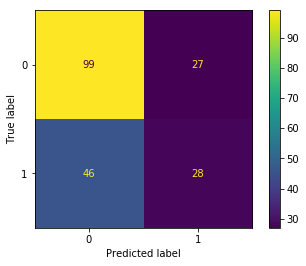

In [61]:
## test_size=0.3 gives best test set performance
curr_train_df = train_df_2.sample(frac=0.85, random_state=42)

clf = KNeighborsClassifier(n_neighbors=25, ## search
                               weights='distance', ## uniform, distance
                               algorithm='brute', 
                               metric='cosine', ## euclidean 
                               n_jobs=None
                              )
clf.fit(curr_train_df[train_cols], curr_train_df['label_2'])
curr_train_probs = clf.predict_proba(curr_train_df[train_cols])[:, 1]
curr_pred_probs = clf.predict_proba(hold_out_df_2[train_cols])[:, 1]
curr_preds = clf.predict(hold_out_df_2[train_cols])
roc_auc_train = roc_auc_score(curr_train_df['label_2'], curr_train_probs)
roc_auc_test = roc_auc_score(hold_out_df_2['label_2'], curr_pred_probs)
conf = confusion_matrix(hold_out_df_2['label_2'], curr_preds)
conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=clf.classes_)
conf_disp.plot()
print("Performance:")
print("Train ROC AUC: ", roc_auc_train)
print("Test ROC AUC: ", roc_auc_test)
print("Confusion Matrix: ")
plt.show()